# 추천 시스템 - 아이템 기반 협업 필터링(Item Based Collaborative Filtering) & 잠재요인 협업필터링 (Latent Factor Collaborative Filtering) - Matrix Factorization
 - 사용자의 입력 평점을 기반으로 상위 10개 앱을 뽑아낸 다음, 가중평점을 기반으로 정렬해서 top5를 추천
 - 위와 같은 방식으로 Matrix Factorization을 이용해 잠재요인을 분석해 추가적으로 5개의 앱을 더 추천
 - 총 10개의 앱을 추천하게 됨
 - 데이터는 kaggle의 https://www.kaggle.com/usernam3/shopify-app-store 를 전처리한 데이터입니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline

- 사용자 평점이 있는 데이터

In [2]:
reviews = pd.read_csv('./dataset/reviews.csv',delimiter = None,encoding='utf-8')
user_rating = reviews[['app_id','author','rating']].dropna(axis=0)
print(user_rating.shape)
print(user_rating.info())
user_rating.head()

(447193, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 447193 entries, 0 to 447316
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   app_id  447193 non-null  object
 1   author  447193 non-null  object
 2   rating  447193 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 13.6+ MB
None


,app_id,author,rating
0,b1da53a4-0474-4700-9620-bf386bc033fb,Consuela,5
1,b1da53a4-0474-4700-9620-bf386bc033fb,L'Atelier Global,5
2,b1da53a4-0474-4700-9620-bf386bc033fb,city'super E-Shop,5
3,b1da53a4-0474-4700-9620-bf386bc033fb,PortableHandwashing.com,5
4,b1da53a4-0474-4700-9620-bf386bc033fb,ICCTUNING,5


- 앱의 가중평점이 있는 데이터

In [3]:
app_df = pd.read_csv('./temp_data/app_df.csv',delimiter = None,encoding='utf-8')
app_rating = app_df[['app_id','wr_rating']].dropna(axis=0)
print(app_rating.shape)
print(app_rating.info())
app_rating.head()

(4750, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4750 entries, 0 to 4749
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   app_id     4750 non-null   object 
 1   wr_rating  4750 non-null   float64
dtypes: float64(1), object(1)
memory usage: 111.3+ KB
None


,app_id,wr_rating
0,9e4748a9-7eda-4814-83b6-0537d44152b1,30.800631
1,d1476138-a608-4bb9-8d39-b30f3ca7617d,87.308207
2,d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,43.588712
3,0ef0087f-3ae5-4dbc-84e0-193b576d82ed,84.941515
4,7aac2a1f-ff03-4f38-aeb7-7619403a6f05,94.171158


### 아이템 기반 협업 필터링을 위한 피벗 테이블
- 아이템 기반 협업 필터링이므로 row가 user 기반이면 안되고, item이 row가 되어야 함 
- 왜냐하면 cosine similarity를 구할 때 row 기반으로 유사도를 측정하기 때문

In [4]:
%time
item_base = user_rating.pivot_table(values='rating', index='app_id', columns='author').fillna(0)
item_base

Wall time: 0 ns


author,"""Accountable Clothing""","""All Things Rugby""","""HOOKED ON LINGERIE""","""LIFT OFF"" by Andrew","""Raggy Stylz"" Doggy Fashion","""The Cure"" For Men","""VEOPODS""","""Visual Biographies®""",# One Deal,#0 Clothes Mentor Columbus & Toledo,...,🍓Ichigo,🎱 G² Billiard Products 🎱,🐾 Houndzy,🐾 bowwow.shop,🐾Comfort4Paws,💨Incensery,🔥Fire Fashion & Decor🔥,🔥🔥🔥hot🌍sales🔥🔥🔥,😍 PaintMaster,🚲 Salatim To Go 🚲
app_id,,,,,,,,,,,,,,,,,,,,,
00014403-ad17-4c9b-bbcf-5adc27ba18a9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000270a8-af0b-4862-82df-25decbcc8d86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006d5af-c461-4bdb-b32e-a4fecd00846b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001ce7ab-14dc-45ce-98f1-1b42b61c86c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00215fb3-ff7c-4111-8f0c-8e7e2a9027fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9fcefb-cb60-4ff3-8ec8-75a6e89b9055,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffda2590-e98f-46b7-8608-ce242bfd0c07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffda8a87-f35e-4d27-bee9-c3088a613e08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### cosine similarity를 이용해 item별로 유사한 것을 측정

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
%%time
item_base_collabor = cosine_similarity(item_base)
item_base_collabor

Wall time: 3min 30s


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

- cosine similarity로 구한 유사도 점수를 컬럼을 매칭하여 데이터 프레임으로 변환

In [7]:
app_sim_df = pd.DataFrame(data=item_base_collabor, index=item_base.index, columns=item_base.index)
app_sim_df

app_id,00014403-ad17-4c9b-bbcf-5adc27ba18a9,000270a8-af0b-4862-82df-25decbcc8d86,0006d5af-c461-4bdb-b32e-a4fecd00846b,001ce7ab-14dc-45ce-98f1-1b42b61c86c1,00215fb3-ff7c-4111-8f0c-8e7e2a9027fb,005739cc-4d50-4013-ad4a-beca69e32037,007a1f24-093e-4de4-bfe8-d9b097f4cf3b,00ad6b55-3a26-42be-a185-ca3bf2a361dc,00b08a94-39ac-4a90-b7a4-d8a177d5d1e1,00be4dc9-4151-477f-aba4-c2ce97fd65d8,...,ff453576-4a68-48ec-8ffe-b1557fbf942b,ff684d29-6792-4fb0-b3e3-0112605a21be,ff6f258a-849f-4ff6-aab4-52c93b28458f,ff7b70fe-336a-4fbb-9556-0e7042e05aa9,ff8e0c0d-50b2-4c93-8c2f-1848b14dc142,ff9fcefb-cb60-4ff3-8ec8-75a6e89b9055,ffda2590-e98f-46b7-8608-ce242bfd0c07,ffda8a87-f35e-4d27-bee9-c3088a613e08,fff053c9-30de-426b-8a5f-3e393ff45ec0,fff4cec3-a140-45bd-b257-fec3759497a0
app_id,,,,,,,,,,,,,,,,,,,,,
00014403-ad17-4c9b-bbcf-5adc27ba18a9,1.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.008093,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.004380,0.0,0.000000,0.00000,0.0
000270a8-af0b-4862-82df-25decbcc8d86,0.00000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0
0006d5af-c461-4bdb-b32e-a4fecd00846b,0.00000,0.0,1.000000,0.0,0.0,0.000000,0.0,0.002687,0.013852,0.0,...,0.0,0.0,0.017135,0.0,0.0,0.013958,0.0,0.000000,0.00000,0.0
001ce7ab-14dc-45ce-98f1-1b42b61c86c1,0.00000,0.0,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0
00215fb3-ff7c-4111-8f0c-8e7e2a9027fb,0.00000,0.0,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9fcefb-cb60-4ff3-8ec8-75a6e89b9055,0.00438,0.0,0.013958,0.0,0.0,0.007681,0.0,0.001131,0.008289,0.0,...,0.0,0.0,0.003536,0.0,0.0,1.000000,0.0,0.001793,0.00839,0.0
ffda2590-e98f-46b7-8608-ce242bfd0c07,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,1.0,0.000000,0.00000,0.0
ffda8a87-f35e-4d27-bee9-c3088a613e08,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.001793,0.0,1.000000,0.00000,0.0


### 현재 사용자가 설치한(리뷰한) 앱과 유사한 앱 추출
 - 자기자신을 제외한 유사도가 높은 상위 10개 앱

In [8]:
nowApp = 'b1da53a4-0474-4700-9620-bf386bc033fb'
recommend_list = app_sim_df[nowApp].sort_values(ascending=False)[1:11]
recommend_list

app_id
243d147e-0a47-4a6b-99a7-700c2c243a9b    0.047721
3623e405-eeca-41de-8e8e-750a40389615    0.040772
9e892751-643a-4829-84aa-81934fad9484    0.040772
ff684d29-6792-4fb0-b3e3-0112605a21be    0.040772
3676737c-2bbc-416a-ba8a-19ec3a5de22f    0.039980
d05f001b-8ded-4590-9346-fd7d20721274    0.039265
6dd7f731-ee55-4533-9874-55c1d197b245    0.034056
7aeb4a85-5128-4df7-8ed2-763a0613e176    0.033386
755453de-abaa-44c4-ade1-fa8e19f43626    0.032947
04b7982b-89e9-44ad-9b6f-f7b7b4247d3d    0.032477
Name: b1da53a4-0474-4700-9620-bf386bc033fb, dtype: float64

### 추출한 10개 앱에 가중평점을 맵핑해서 정렬 후 상위 5개 앱 추출

In [9]:
wr_rating = pd.merge(left=recommend_list.to_frame(), right=app_rating, how='left', on='app_id')
recommend_app = wr_rating.sort_values(by='wr_rating', ascending=False).iloc[:5,:]
recommend_app

,app_id,b1da53a4-0474-4700-9620-bf386bc033fb,wr_rating
1,3623e405-eeca-41de-8e8e-750a40389615,0.040772,93.603550
2,9e892751-643a-4829-84aa-81934fad9484,0.040772,93.603550
3,ff684d29-6792-4fb0-b3e3-0112605a21be,0.040772,93.603550
4,3676737c-2bbc-416a-ba8a-19ec3a5de22f,0.039980,93.017823
8,755453de-abaa-44c4-ade1-fa8e19f43626,0.032947,66.377689


### 잠재 기반 협업 필터링을 위한 피벗 테이블 생성
- 특정 '앱'과 비슷한 앱을 추천해주기 위해 사용자-앱 기준의 데이터를 앱-사용자 기준으로 변환
- 행렬을 전치시킴

In [10]:
%%time
latent_base = user_rating.pivot_table(values='rating', index='app_id', columns='author').fillna(0)
latent_base

Wall time: 1min 34s


author,"""Accountable Clothing""","""All Things Rugby""","""HOOKED ON LINGERIE""","""LIFT OFF"" by Andrew","""Raggy Stylz"" Doggy Fashion","""The Cure"" For Men","""VEOPODS""","""Visual Biographies®""",# One Deal,#0 Clothes Mentor Columbus & Toledo,...,🍓Ichigo,🎱 G² Billiard Products 🎱,🐾 Houndzy,🐾 bowwow.shop,🐾Comfort4Paws,💨Incensery,🔥Fire Fashion & Decor🔥,🔥🔥🔥hot🌍sales🔥🔥🔥,😍 PaintMaster,🚲 Salatim To Go 🚲
app_id,,,,,,,,,,,,,,,,,,,,,
00014403-ad17-4c9b-bbcf-5adc27ba18a9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000270a8-af0b-4862-82df-25decbcc8d86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0006d5af-c461-4bdb-b32e-a4fecd00846b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001ce7ab-14dc-45ce-98f1-1b42b61c86c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00215fb3-ff7c-4111-8f0c-8e7e2a9027fb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9fcefb-cb60-4ff3-8ec8-75a6e89b9055,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffda2590-e98f-46b7-8608-ce242bfd0c07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ffda8a87-f35e-4d27-bee9-c3088a613e08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 특이값 분해 SVD(Singular Value Decomposion)
 - truncated SVD는 시그마 행렬의 대각원소(특이값) 가운데 상위 n개만 골라낸 것이다.
 - 이렇게 하면 기존 행렬 A의 성질을 100% 복원할 수는 없지만, (그 만큼 데이터 정보를 압축) 기존 행렬과 거의 근사한 값이 나오게 된다.

In [11]:
from sklearn.decomposition import TruncatedSVD

- 12개의 component로 차원을 축소
- 이렇게 하면 전체의 앱들이 어떤 12개의 요소의 값을 가지게 됨

In [12]:
svd = TruncatedSVD(n_components=12, random_state=42)
matrix = svd.fit_transform(latent_base)

print(matrix[0])
print(matrix.shape)

[0.00754845 0.02534806 0.02848146 0.0148049  0.00737026 0.00777485
 0.07665963 0.08052895 0.04655627 0.12534656 0.00792175 0.10124126]
(3733, 12)


- 이렇게 나온 데이터를 활용해서 피어슨 상관계수를 구함

In [13]:
corr = np.corrcoef(matrix)
corr.shape

(3733, 3733)

- 그래프를 그리기 위해 200개만 추출

<AxesSubplot:>

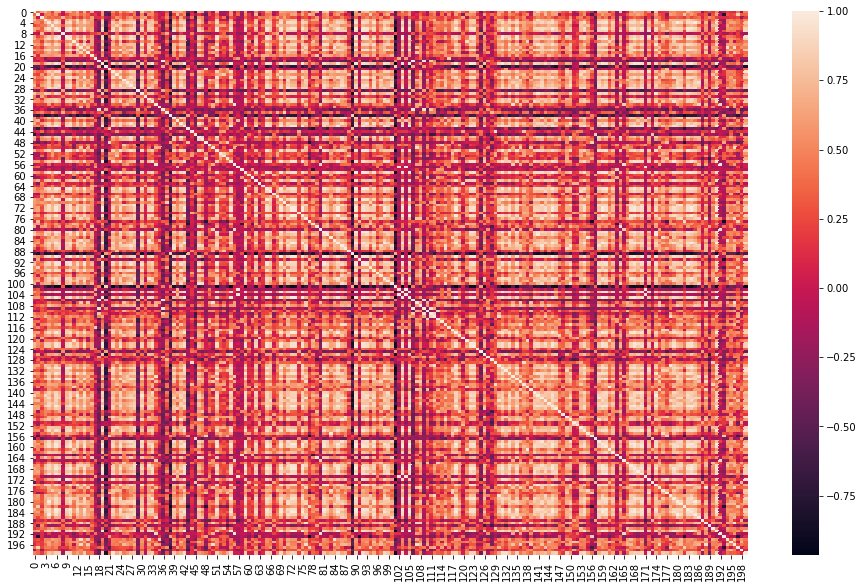

In [14]:
corr2 = corr[:200, :200]
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

### 위에서 구한 상관계수를 이용해서 특정 앱과 상관계수가 높은 앱 상위 5개를 추출함

In [16]:
app_title = latent_base.index
app_title_list = list(app_title) # 앱 전체 목록
coffey_hands = app_title_list.index(nowApp) # 해당 앱의 인덱스
coffey_hands

2593

In [41]:
corr_coffey_hands = corr[coffey_hands] # 특정 앱과 다른 앱들의 상관계수를 추출
coffey_hands_df = pd.DataFrame(data=corr_coffey_hands, index=app_title, columns=['corr']) # 앱과 상관계수를 맵핑
recommend = coffey_hands_df.loc[coffey_hands_df['corr'] >= 0.95]  # 상관계수가 0.95 이상인 영화를 추출
recommend_latent = recommend.sort_values(by='corr', ascending=False)[1:6] # 상관계수로 정렬 후 상위 5개 앱만 추출
recommend_latent

,corr
app_id,
27b9c400-cce7-45ed-9652-4c1030937811,0.990447
243d147e-0a47-4a6b-99a7-700c2c243a9b,0.987950
7aeb4a85-5128-4df7-8ed2-763a0613e176,0.986717
8e37fe77-7884-4af3-a758-5a75cbafc58c,0.986116
4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb,0.985633


### 평점으로 추천된 5개 앱과 잠재요인으로 추천된 앱 5개를 합쳐서 사용자에게 총 10개의 앱을 추천

In [47]:
result = pd.concat([recommend_app, recommend_latent.reset_index()], axis=0).reset_index(drop=True)
result['app_id']

0    3623e405-eeca-41de-8e8e-750a40389615
1    9e892751-643a-4829-84aa-81934fad9484
2    ff684d29-6792-4fb0-b3e3-0112605a21be
3    3676737c-2bbc-416a-ba8a-19ec3a5de22f
4    755453de-abaa-44c4-ade1-fa8e19f43626
5    27b9c400-cce7-45ed-9652-4c1030937811
6    243d147e-0a47-4a6b-99a7-700c2c243a9b
7    7aeb4a85-5128-4df7-8ed2-763a0613e176
8    8e37fe77-7884-4af3-a758-5a75cbafc58c
9    4ee3c37d-7ad9-4a98-83d0-7b3ff8cf6cfb
Name: app_id, dtype: object